In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.TDEM import geteref, Problem3DIP_Linear, SurveyLinear
from simpegEMIP.TDEM import Survey, Rx
from simpegEMIP.TDEM import Problem3DEM_e, Problem3D_e
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
eps = np.finfo(float).eps

use sampling frequency as 50kHz, ramp time of 200us (K. Nakayama and A. Saito, 2016)
WISTEM uses 3.5m rectangular, (K.Nakayama,2019) which has equivalent area for 2.0m circular. 

In [2]:
tx_radius = (3.5)/(np.sqrt(np.pi))
tx_circumference = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
n_turns = 5
rmp_time = 200e-6
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [3]:
#cs, ncx, ncz, npad = 10., 25, 20, 18
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
pf, npadx, npadz = 1.3 , 26, 26
hx = [(csx, ncx), (csx, npadx, pf)]
hz = [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
print(f'number of mesh {mesh.nC}')
print(csx)

number of mesh 31752
0.4936658856042868


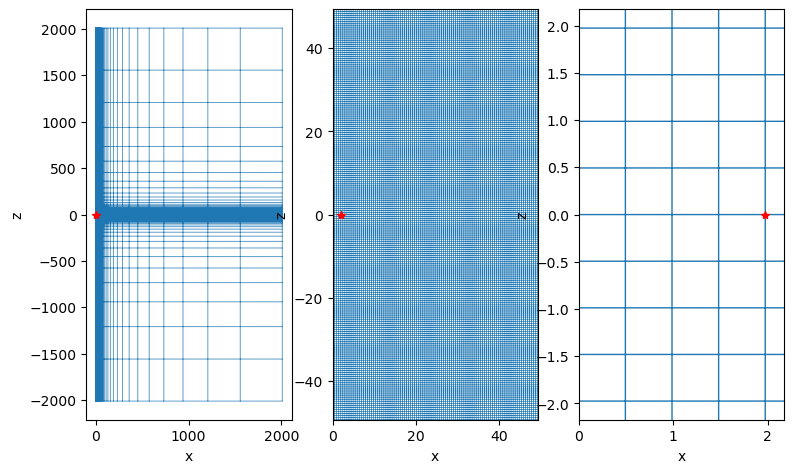

In [4]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plotGrid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plotGrid(ax=ax[1], show_it=False, linewidth=0.5)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[2] =  mesh.plotGrid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)

for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)

In [5]:
sigma_sea = 3.0
sigma_seabed = 1.0
sigma_target = 1/0.15
eta_target = 0.3
tau_target = 1.0e-3
c_target = 0.8
thick_target = 30.
tx_height = csx
print(tx_height)

0.4936658856042868


In [6]:
sigmaInf = np.ones(mesh.nC)*sigma_sea
inds_layer = np.logical_and(mesh.gridCC[:,2]<-tx_height, mesh.gridCC[:,2]>-tx_height-thick_target)
sigmaInf[inds_layer] = sigma_target
inds_bed = mesh.gridCC[:,2] <= - tx_height-thick_target
sigmaInf[inds_bed] = sigma_seabed


In [7]:
eta = np.zeros(mesh.nC)
eta[inds_layer] = eta_target
tau=np.ones(mesh.nC)
tau[inds_layer] = tau_target
c=np.ones(mesh.nC)
c[inds_layer] = c_target


In [13]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  10)]
tstrt, tend, logstep = 1e-4, 4e-3, 1/20
steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
time_rec = time_clc
#time_clc = time_clc[time_clc < tend+eps ]
#time_rec = np.power(10,np.arange(np.log10(tstrt), np.log10(tend), logstep))
print(time_rec[0:2])

[2.e-06 4.e-06]


In [14]:
# # Use VTEM wave form for just moment
# dt = 1.47e-3
# tpeak = 2.73e-3
# t0 = tpeak + dt
# t1, t2, t3 = dt, t0-0.001365, t0

In [15]:
# Get EM data
srcloc = np.array([[0., 0., 0.]])

#waveform = EM.TDEM.Src.StepOffWaveform()
waveform = EM.TDEM.Src.RampOffWaveform(offTime = rmp_time)
#waveform = EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.)
# rxloc = np.array([[tx_radius, 0., 0.]])
# rx = Rx.Point_e(locs=rxloc, times= time_clc, orientation='y')

rxloc = np.array([[0, 0., 0.]])
#rx = Rx.Point_dbdt(locs=rxloc, times= time_rec+rmp_time, orientation='z')
rx = Rx.Point_dbdt(locs=rxloc, times= time_rec, orientation='z')

src = EM.TDEM.Src.CircularLoop([rx],radius=tx_radius, waveform=waveform, loc=srcloc)
survey = Survey([src])
#prb = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps =time_steps
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey)


In [32]:
print(len(time_clc))
print(len(time_rec))

460
460


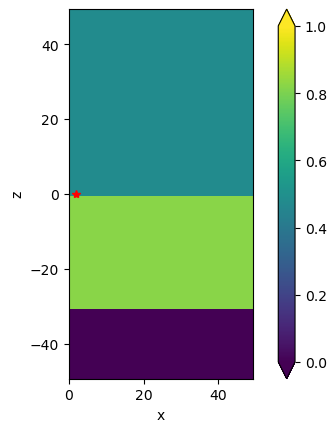

In [16]:
cb= mesh.plotImage(np.log10(sigmaInf))
plt.colorbar(cb[0], ax=plt.gca(), extend='both')
plt.plot(src.radius,0,'r*')
cb[0].set_clim(1, 0) 
cb[0].set_label('$ \log_{10}SurveyLinear $')
plt.xlim(0., ncx*csx)
plt.ylim(-ncz*csz, ncz*csz )
plt.gca().set_aspect('equal')

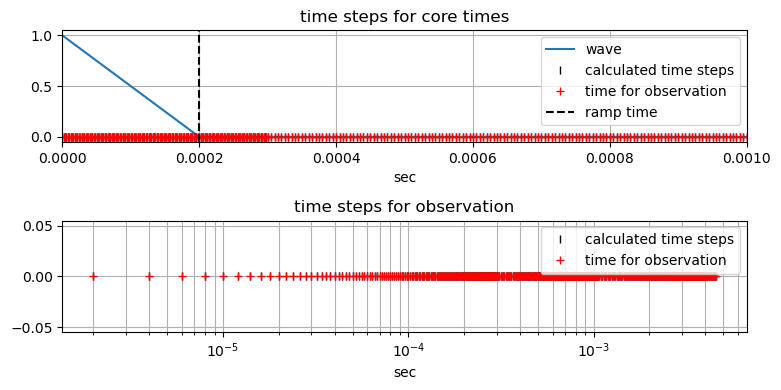

In [22]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(prb_emip.times, [waveform.eval(t) for t in prb_emip.times],label='wave')
ax[0].plot(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
#ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].plot(time_rec, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-3)#time_steps[0][0]*time_steps[0][1])
#ax[0].set_xlim(3.e-3,5e-3)#time_steps[0][0]*time_steps[0][1])

ax[0].set_title('time steps for core times')

ax[1].semilogx(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

In [23]:
fields_emip = prb_emip.fields(sigmaInf)

C:\Users\81805\anaconda3\envs\simpegEMIP\lib\site-packages\SimPEG\Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [26]:
# Get data from fields
data_emip = survey.dpred(sigmaInf, f=fields_emip)

In [27]:
dpred_emip = -data_emip * n_turns *tx_area

In [ ]:
plt.loglog(time_rec, dpred_emip, 'k-', label="emip" )
plt.loglog(time_rec, -dpred_emip, 'k--', label="empi_negative")
plt.legend()
#plt.ylim([1e-7,1e-2])
plt.ylim(bottom=1e-7)

plt.grid(True, which='both')

In [17]:
Jpol=prb_emip.jpoln1

In [18]:
print(fields_emip.shape)
print(Jpol.shape)

(31878, 1, 461)
(31878, 1)


In [28]:
# Adjust ramp time and export data in numpy format
np_save = np.zeros((2,len(time_rec)))
np_save[0,:] = time_rec
np_save[1,:] = dpred_emip
np.save("14_Validation_simpegEMIP.npy", np_save)

In [29]:
np.save("14_fields_emip.npy", fields_emip)
np.save("14_time_clc.npy", time_clc)

In [32]:
# Get EM data
srcloc = np.array([[0., 0., 0.]])

waveform = EM.TDEM.Src.StepOffWaveform()
#waveform = EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.)
# rxloc = np.array([[tx_radius, 0., 0.]])
# rx = Rx.Point_e(locs=rxloc, times= time_clc, orientation='y')

rxloc = np.array([[0, 0., 0.]])
rx = Rx.Point_dbdt(locs=rxloc, times= time_clc, orientation='z')

src = EM.TDEM.Src.CircularLoop([rx],radius=tx_radius, waveform=waveform, loc=srcloc)
survey_em = Survey([src])

prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_em.timeSteps =time_steps
prb_em.Solver = PardisoSolver
prb_em.pair(survey_em)

In [33]:
fields_em = prb_em.fields(sigmaInf)

In [35]:
data_em = survey_em.dpred(sigmaInf, f=fields_em)

In [97]:
cur = []
for t in prb.times:
    cur.append(src.waveform.eval(t))
cur = np.hstack(cur)

In [227]:
eref = geteref(fields_em[:,0,:], mesh, option=None, tInd=4)
#eref = geteref(fields_em[:,0,:], mesh, option=max) 

In [228]:
print(eref)

[-7.02795593e-16 -1.38041789e-15 -2.02628865e-15 ... -1.07610065e-13
 -1.12416763e-13 -1.02340525e-13]


In [229]:

rx = Rx.Point_dbdt(locs=rxloc, times= time_clc, orientation='z')
#rx_ip = Rx.Point_e(locs=rxloc, times= time_clc, orientation='y')
src = EM.TDEM.Src.CircularLoop([rx],radius=tx_radius, waveform=waveform, loc=srcloc)
survey_ip = SurveyLinear([src_ip])
prb_ip = Problem3DIP_Linear(
    mesh, 
    sigmaInf=sigmaInf, 
    eta=eta, 
    tau=tau, 
    c=c,
    actinds=inds_act,
#    wave_option = "step_ramp",
    tlags=[0, rmp_time, 2*rmp_time, 3*rmp_time]
)
prb_ip.Solver = PardisoSolver
prb_ip.pair(survey_ip)
prb_ip.set_eref(eref)


In [230]:
data_ip= survey_ip.dpred([])

>> Compute Sensitivity matrix
 1 / 1

In [231]:
print(sum(data_ip))

1.3499356343612359e-05


In [232]:
data_sum = data_em + data_ip

In [233]:
# Get EMF(V/A)
dpred_emip = -data_emip * n_turns *tx_area
dpred_sum = -data_sum * n_turns *tx_area

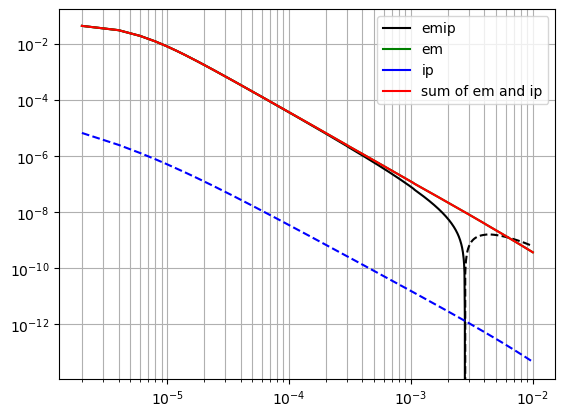

In [234]:
plt.loglog(time_clc, -data_emip, 'k-', label="emip" )
plt.loglog(time_clc,  data_emip, 'k--')
plt.loglog(time_clc, -data_em, 'g-', label="em" )
plt.loglog(time_clc,  data_em, 'g--')
plt.loglog(time_clc, -data_ip, 'b-', label="ip" )
plt.loglog(time_clc,  data_ip, 'b--')
plt.loglog(time_clc, -data_sum, 'r-', label="sum of em and ip" )
plt.loglog(time_clc,  data_sum, 'r--')
plt.legend()
plt.grid(True, which='both')

In [30]:
# Adjust ramp time and export data in numpy format
time_simpegemip = time_clc[1:]-rmp_time
dpred_simpegemip = dpred_emip [1:]
np_save = np.zeros((2,len(time_simpegemip)))
np_save[0,:] = time_simpegemip
np_save[1,:] = dpred_simpegemip

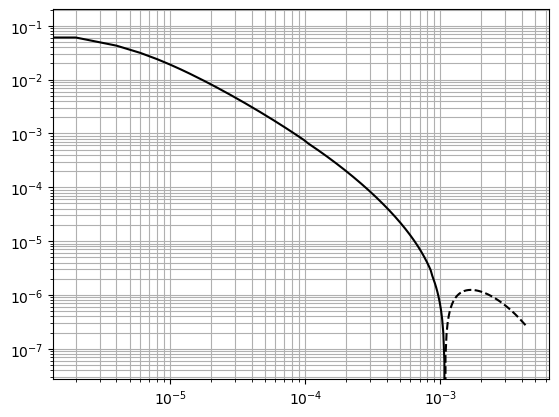

In [31]:
plt.loglog(time_simpegemip, dpred_simpegemip, 'k-')
plt.loglog(time_simpegemip, -dpred_simpegemip, 'k--')
plt.grid(True, which='both')

In [ ]:
%%time
e_emip, data_emip, cur = get_em_data(sigmaInf, eta, tau, c, data_type='emip')

In [ ]:
%%time
e_em, data_em, cur = get_em_data(sigmaInf)
eref = geteref(e_em[:,0,:], mesh, option=None, tInd=20) 
ip = get_ip_data(sigmaInf, eref, eta, tau, c)

In [ ]:
data = ip + data_em

In [ ]:
times = np.logspace(np.log10(2e-5), np.log10(0.009), 51)

In [ ]:
plt.loglog(times, -data, 'k')
plt.loglog(times, data, '--k')
plt.loglog(times, -data_emip, 'kx')
plt.loglog(times, data_emip, 'kx')
plt.loglog(times, -data_em, 'b')

In [ ]:
Rx.Point_dbdt?

In [ ]:
EM.TDEM.Src.CircularLoop?

In [ ]:
EM.TDEM.Src.StepOffWaveform?

In [ ]:
def get_em_data(sigma, eta=None, tau=None, c=None, data_type='em'):
    # rxloc = np.array([[0., 0., 30.]])
    # srcloc = np.array([[0., 0., 30.]])
    rxloc = np.array([[0., 0., 0.]])
    srcloc = np.array([[0., 0., 0.]])
    dt = 1.47e-3
    tpeak = 2.73e-3
    t0 = tpeak + dt
    waveform = EM.TDEM.Src.StepOffWaveform()
    rx_z = Rx.Point_dbdt(locs=rxloc, times= time_rec, orientation='z')
    src = EM.TDEM.Src.CircularLoop([rx_z], waveform=waveform, loc=srcloc)
    survey = Survey([src])
    if data_type == 'em':
        prb = Problem3DEM_e(mesh, sigma=sigma)
    elif data_type == 'emip':
        prb = Problem3D_e(mesh, sigmaInf=sigma, eta=eta, tau=tau, c=c)
    prb.timeSteps =time_clc
    prb.Solver = PardisoSolver
    prb.pair(survey)
    e = prb.fields(sigmaInf)
    data = survey.dpred(sigmaInf, f=e)
    # waveform
    cur = []
    for t in prb.times:
        cur.append(src.waveform.eval(t))
    cur = np.hstack(cur)
    return e, data, cur

In [ ]:
def get_ip_data(sigma, eref, eta, tau, c):
    rxloc = np.array([[0., 0., 30.]])
    srcloc = np.array([[0., 0., 30.]])    
    rx_ip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
    src_ip = EM.TDEM.Src.CircularLoop([rx_ip], loc=srcloc)
    dt = 1.47e-3
    tpeak = 2.73e-3
    t0 = tpeak + dt
    survey_ip = SurveyLinear([src_ip])
    t1, t2, t3 = dt, t0-0.001365, t0
    prb_ip = Problem3DIP_Linear(
        mesh, 
        sigmaInf=sigmaInf, 
        eta=eta, 
        tau=tau, 
        c=c, 
        actinds = actinds,
        tlags = [0., t1, t2, t3]
    )
    prb_ip.Solver = PardisoSolver
    prb_ip.pair(survey_ip)
    prb_ip.set_eref(eref)
    ip_approx = survey_ip.dpred([])
    return ip_approx